Time Series Analysis for Dynamical Systems


# 1. Problem Definition: Short Term Load Forecasting

Load forecasting within the context of energy demand. It is an open-access data published as the appendix Hong et al. (2016). The data consists of three years of hourly electricity load and temperatures.


# 2. Preparing the environment

Import the Python libraries that we will need to (i) load the data, (ii) analyze it, (iii) create our model, (iv) process the results.

In [1]:
!pip install ipython-autotime
%load_ext autotime

time: 0 ns (started: 2024-09-13 13:03:00 +02:00)



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Libraries

In [2]:
#Local Installations
!pip install statsmodels

time: 1.56 s (started: 2024-09-13 13:03:00 +02:00)



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
#Importing the necessary libraries
import math
import numpy as np
import pandas as pd
import datetime as dt
import os
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
import statsmodels.api as sm
import warnings
import matplotlib.dates as mdates
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

time: 3.39 s (started: 2024-09-13 13:03:02 +02:00)


In [4]:
# Data Preparation and Scoring
from sklearn import preprocessing as pp
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from matplotlib.colors import LogNorm

time: 141 ms (started: 2024-09-13 13:03:05 +02:00)


In [5]:
# ML Algorithms to be used
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.svm import SVR

time: 63 ms (started: 2024-09-13 13:03:05 +02:00)


# 3. Pre-processing


In [6]:
cwd = os.getcwd()
DATA_PATH = os.path.join(cwd, '..', 'data')
RAW_DATA_PATH = os.path.join(DATA_PATH, 'raw')
def read_Data():
    data_path = os.path.join(RAW_DATA_PATH, "energy.csv") #,parse_dates=[['Date', 'Hour']]) if date and hour to be merged here.
    data = pd.read_csv(data_path)
    return data

time: 0 ns (started: 2024-09-13 13:03:05 +02:00)


In [7]:
data = read_Data()

time: 31 ms (started: 2024-09-13 13:03:05 +02:00)


In [8]:
data = data.dropna()
data.loc[data.Hour == 24, "Hour"] = 0
data.iloc[23]
#Converting time hour into string:
data['Hour']= data['Hour'].apply(str)
#Merging Columns:
data['Date']= data['Date']+' '+ data['Hour']
data = data.drop(['Hour'],axis=1)
# convert the column to datetime type:
datetime_series = pd.to_datetime(data['Date'],format='%d/%m/%Y %H')
#Create datetime index and pass it:
datetime_index = pd.DatetimeIndex(datetime_series.values)
#Updating the indices:
data=(data.set_index(datetime_index)).drop(['Date'],axis=1)
data = data.sort_index()

time: 219 ms (started: 2024-09-13 13:03:05 +02:00)


# ML Algorithms for Forecasting: SVM - II 

## Organizing the Feature Matrix

In [9]:
#Checking Data:
data.sample(3)

,load,T
2006-02-16 17:00:00,3608.0,40.33
2014-10-19 11:00:00,3167.0,46.67
2006-01-05 13:00:00,3976.0,29.00


time: 16 ms (started: 2024-09-13 13:03:06 +02:00)


In [10]:
#Adding statistics features in dataframes:
#------------------------------------------------
#Lets use only the load data;
load_data = data[['load']]
#Defining the window width:
width = 24
#Calling Rolling:
window = load_data.rolling(window=width)
#Lets save as a new DF. We will add min, mean and max to the load column:
new_dataframe = pd.concat([window.median(), window.std(),data['T'], data['load']], axis=1)
new_dataframe.columns = ['median', 'std','T', 'load']
new_dataframe = new_dataframe.dropna() 
new_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78865 entries, 2006-01-01 23:00:00 to 2014-12-31 23:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   median  78865 non-null  float64
 1   std     78865 non-null  float64
 2   T       78865 non-null  float64
 3   load    78865 non-null  float64
dtypes: float64(4)
memory usage: 3.0 MB
time: 47 ms (started: 2024-09-13 13:03:06 +02:00)


In [11]:
new_dataframe.head(1)

,median,std,T,load
2006-01-01 23:00:00,3512.0,471.067697,24.33,3255.0


time: 0 ns (started: 2024-09-13 13:03:06 +02:00)


## Building the X Matrix and Labels

Adding the temporal data with sliding intervals in time. Lets first look with an illustration:

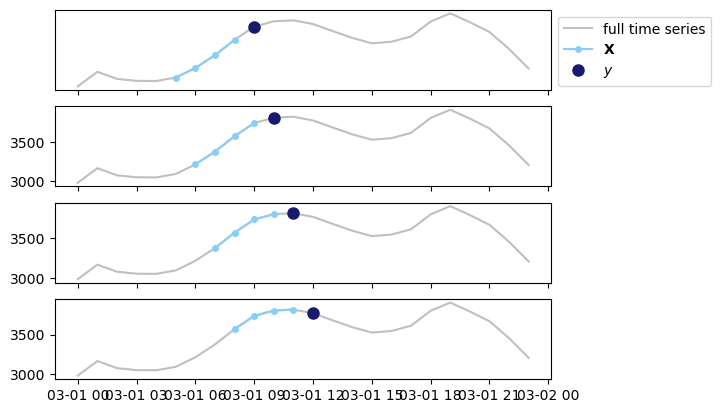

time: 781 ms (started: 2024-09-13 13:03:06 +02:00)


In [12]:
#finding the indices as integers for time substraction below:
start = np.where(new_dataframe.index == '2014-03-01 00:00:00')[0][0]
middle = np.where(new_dataframe.index == '2014-03-01 12:00:00')[0][0]
end = np.where(new_dataframe.index == '2014-03-02 00:00:00')[0][0]
#sliding window width:
window = 4
#Plotting a sliding interval sample:
fig, ax = plt.subplots(nrows=4,sharex=True);
for i in range(4): 
    full = new_dataframe.iloc[start:end]['load']
    train = new_dataframe.iloc[middle - i - window:middle - i ]['load']
    predict = new_dataframe.iloc[middle - i:middle - i + 1]['load']

    ax[3-i].plot((full + 2*i),c='grey', alpha=0.5);
    ax[3-i].plot((train + 2*i),c=colors['lightskyblue'], markersize=4,marker='o')
    ax[3-i].plot((predict + 2*i),c=colors['midnightblue'], markersize=8,marker='o', linestyle='')

ax[0].get_yaxis().set_ticks([]);
ax[0].legend(['full time series','$\mathbf{X}$','$y$'],bbox_to_anchor=(1, 1));


Lets follow the same logic and create feature matrix A in this way.

In [13]:
#finding the indices as integers for time substraction below:
start = np.where(new_dataframe.index == '2012-09-01 00:00:00')[0][0]
end = np.where(new_dataframe.index == '2014-11-04 00:00:00')[0][0]
#setting windows width:
window = 48
#emply datalist
dataX = []
dataY = []
column_names = []
for i in range(start,end-window):

    # Slice a window of features
    dataX.append((new_dataframe.iloc[i:i+window].to_numpy()).ravel())
    dataY.append(new_dataframe['load'].iloc[i+window] )

for j in range (1,window+1):
      column_names.append(['median_t_'+str(j),'std_t_'+str(j),'T_t_'+str(j),'load_t_'+str(j)])

column_names = itertools.chain(*column_names)
dataX = pd.DataFrame(np.vstack(dataX),index=new_dataframe.iloc[start+window:end].index)
dataX.columns = column_names
dataY =pd.Series(dataY,index=new_dataframe.iloc[start+window:end].index)
dataY.column = ['true_load']

time: 1.17 s (started: 2024-09-13 13:03:06 +02:00)


In [14]:
#Original DF:
new_dataframe.loc['2012-09-01 00:00:00':'2012-09-04 00:00:00'].head(6)

,median,std,T,load
2012-09-01 00:00:00,3750.5,593.535976,59.33,2719.0
2012-09-01 01:00:00,3750.5,588.651369,69.67,2817.0
2012-09-01 02:00:00,3750.5,584.145753,67.33,2664.0
2012-09-01 03:00:00,3750.5,580.500794,69.33,2580.0
2012-09-01 04:00:00,3750.5,577.913412,67.67,2537.0
2012-09-01 05:00:00,3750.5,581.252095,65.00,2525.0


time: 15 ms (started: 2024-09-13 13:03:08 +02:00)


In [15]:
dataX.head(2)

,median_t_1,std_t_1,T_t_1,load_t_1,median_t_2,std_t_2,T_t_2,load_t_2,median_t_3,std_t_3,...,T_t_46,load_t_46,median_t_47,std_t_47,T_t_47,load_t_47,median_t_48,std_t_48,T_t_48,load_t_48
2012-09-03 00:00:00,3750.5,593.535976,59.33,2719.0,3750.5,588.651369,69.67,2817.0,3750.5,584.145753,...,64.67,3270.0,3107.5,400.451258,62.0,3070.0,3107.5,400.479656,60.00,2825.0
2012-09-03 01:00:00,3750.5,588.651369,69.67,2817.0,3750.5,584.145753,67.33,2664.0,3750.5,580.500794,...,62.00,3070.0,3107.5,400.479656,60.0,2825.0,3107.5,398.969315,64.67,2630.0


time: 15 ms (started: 2024-09-13 13:03:08 +02:00)


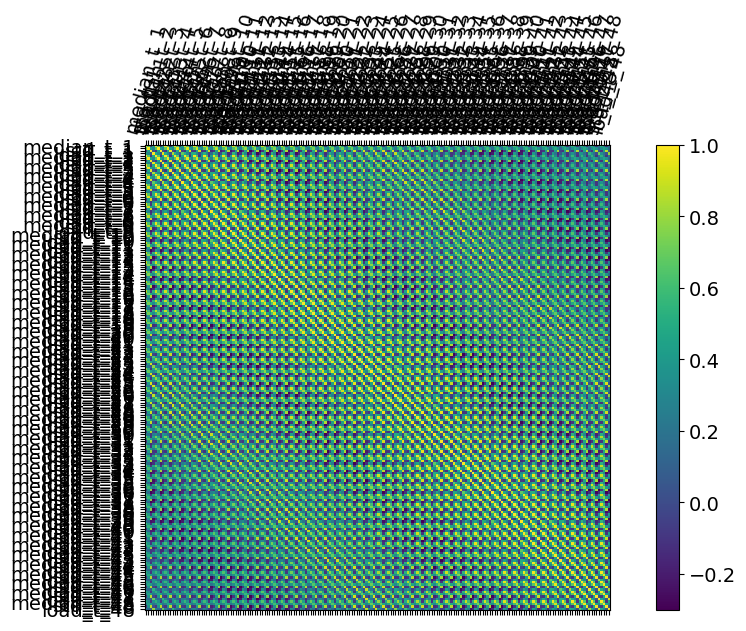

time: 2.98 s (started: 2024-09-13 13:03:08 +02:00)


In [16]:
# Correlation Matrix
correlationMatrix = pd.DataFrame(dataX).corr() 

f = plt.figure(figsize=(12, 6))
plt.matshow(correlationMatrix, fignum=f.number)
plt.xticks(range(dataX.shape[1]), dataX.columns, fontsize=14, rotation=75)
plt.yticks(range(dataX.shape[1]), dataX.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()

In [17]:
#Rescaling the data
featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])
#Looking into the statistics again:
dataX.describe()

,median_t_1,std_t_1,T_t_1,load_t_1,median_t_2,std_t_2,T_t_2,load_t_2,median_t_3,std_t_3,...,T_t_46,load_t_46,median_t_47,std_t_47,T_t_47,load_t_47,median_t_48,std_t_48,T_t_48,load_t_48
count,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,...,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04
mean,4.126890e-16,2.446229e-14,-3.181892e-15,1.256010e-16,1.614870e-16,2.526374e-14,-3.576638e-15,-2.392400e-17,-1.256010e-16,2.497665e-14,...,-2.775184e-15,-2.721355e-16,-6.100619e-16,2.413333e-14,-3.050310e-15,-1.824205e-16,6.100619e-16,2.333786e-14,-2.954614e-15,-1.794300e-16
std,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,...,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00
min,-2.311026e+00,-2.568864e+00,-3.149160e+00,-2.364007e+00,-2.310945e+00,-2.568901e+00,-3.149111e+00,-2.363968e+00,-2.310863e+00,-2.568927e+00,...,-3.148892e+00,-2.364704e+00,-2.310965e+00,-2.569386e+00,-3.148870e+00,-2.364718e+00,-2.311106e+00,-2.569493e+00,-3.148836e+00,-2.364747e+00
25%,-6.392120e-01,-6.328903e-01,-7.643083e-01,-7.708135e-01,-6.391302e-01,-6.328301e-01,-7.642519e-01,-7.707941e-01,-6.390483e-01,-6.327681e-01,...,-7.617216e-01,-7.714148e-01,-6.371107e-01,-6.309856e-01,-7.616627e-01,-7.714386e-01,-6.371837e-01,-6.308675e-01,-7.616067e-01,-7.714603e-01
50%,-1.347291e-01,-1.008269e-01,9.308555e-02,1.184520e-01,-1.354634e-01,-1.008014e-01,9.314447e-02,1.184610e-01,-1.361976e-01,-1.007916e-01,...,7.950615e-02,1.196863e-01,-1.357709e-01,-1.023340e-01,7.957783e-02,1.196574e-01,-1.358235e-01,-1.022454e-01,7.964181e-02,1.196396e-01
75%,6.215871e-01,4.280362e-01,7.966014e-01,6.798121e-01,6.212612e-01,4.280328e-01,7.966624e-01,6.798144e-01,6.213435e-01,4.278247e-01,...,8.007057e-01,6.792978e-01,6.219543e-01,4.269190e-01,8.007884e-01,6.792656e-01,6.219327e-01,4.268832e-01,8.008591e-01,6.792504e-01
max,4.123172e+00,4.490247e+00,2.443456e+00,3.418892e+00,4.123255e+00,4.490566e+00,2.443522e+00,3.418862e+00,4.123339e+00,4.490861e+00,...,2.449162e+00,3.418543e+00,4.124801e+00,4.495797e+00,2.449270e+00,3.418495e+00,4.124922e+00,4.495857e+00,2.449356e+00,3.418492e+00


time: 422 ms (started: 2024-09-13 13:03:11 +02:00)


In [18]:
# Train-Test Split:
# We will split the data as training and test. No need for validation here. 
train_start_dt = '2014-10-01'
test_start_dt = '2014-11-01'
test_end_dt = '2014-11-04'
#Lets use the same notation: X_train, X_test, y_train, y_test
X_train = dataX.copy()[(dataX.index >= train_start_dt)& (dataX.index < test_start_dt)]
y_train = dataY.copy()[(dataY.index >= train_start_dt)& (dataY.index < test_start_dt)]

X_test =  dataX.copy()[(dataX.index >= test_start_dt) & (dataX.index < test_end_dt)]
y_test =  dataY.copy()[(dataY.index >= test_start_dt) & (dataY.index < test_end_dt)]


print('Train data shape: ', X_train.shape, y_train.shape)
print('Test data shape: ', X_test.shape, y_test.shape)

Train data shape:  (744, 192) (744,)
Test data shape:  (72, 192) (72,)
time: 46 ms (started: 2024-09-13 13:03:11 +02:00)


## Model Training and Predictions

In [19]:
# Hyperparameters:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#

#__________________________________________________________________________________________
#___Notes__________________________________________________________________________________
#Radial Basis Function (RBF) kernel, two parameters must be considered: C and gamma. 

#The parameter C, common to all SVM kernels, trades off misclassification of training examples 
#against simplicity of the decision surface. 
#A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly. 
#The strength of the regularization is inversely proportional to C. Large C => little regularization; Low C => higher regularization

#gamma defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected.
#__________________________________________________________________________________________

kernel='linear' 
gamma='scale' #Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. When scaled, uses 1 / (n_features * X.var()) as value of gamma.
C=1.0
epsilon=0.1    # Default
shrinking=True # Whether to use the shrinking heuristic. 
tol=0.00001

#Setting the model:
svr = SVR(kernel= kernel, gamma=gamma, tol=tol, C=C, epsilon=epsilon, shrinking=shrinking)

time: 0 ns (started: 2024-09-13 13:03:11 +02:00)


In [20]:
# Model Training:
model = svr
#Fitting the model according to given data:
model.fit(X_train, y_train)

SVR(kernel='linear', tol=1e-05)

time: 47 ms (started: 2024-09-13 13:03:11 +02:00)


In [21]:
#Model Predictions:
#------------------
#scoreTraining = model.score(X_train, y_train)
#print('-----------------------------------')
#print('SVM Regression Training R^2 Score: ', scoreTraining)
#print('-----------------------------------')
scoreValidation = model.score(X_test, y_test)
print('-----------------------------------')
print('SVM Regression Validation R^2 Score: ', scoreValidation)
print('-----------------------------------')

-----------------------------------
SVM Regression Validation R^2 Score:  0.9235792821874813
-----------------------------------
time: 16 ms (started: 2024-09-13 13:03:11 +02:00)


In [22]:
#Visual Comparisons
#------------------
# Lets get the predictions first:
y_predict = pd.Series(svr.predict(X_test),index=y_test.index)

time: 0 ns (started: 2024-09-13 13:03:11 +02:00)


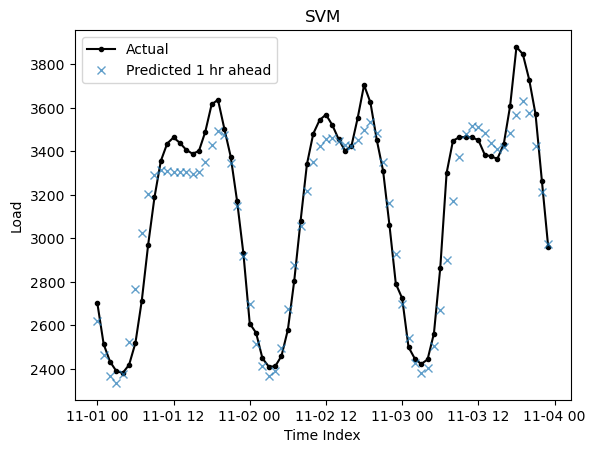

time: 281 ms (started: 2024-09-13 13:03:11 +02:00)


In [23]:
#Plotting the Figure:
plt.figure();
plt.plot(y_test, 'k.-');
plt.plot(y_predict, 'x', alpha=0.70);

plt.legend(['Actual',
            'Predicted 1 hr ahead'
            ]);
plt.ylabel('Load');
plt.xlabel('Time Index');
plt.title('SVM');

### Forecasting further in time...

Lets use the SVM to predict further horizons by just using the training wisdom. Here we will follow a similar anology. We need to update the passed information about the past as we progress. Here, it is a bit more difficult as we need to update the created features as well. Lets see how it can be implemented.


In this section, the goal is to use the Support Vector Machine (SVM) model to make predictions further into the future. This process is called forecasting.

To accomplish this, we need to iteratively update the past information as we progress in time, making predictions for future time steps. This is a more challenging task because we also need to update the features used in the model as we move forward.

The basic idea can be summarized in the following steps:

1. `Train the SVM model on the available historical data.`
2. `Make a prediction for the next time step using the trained model.`
3. `Update the historical data and features with the new prediction.`
4. `Go back to step 2, using the updated historical data and features to make a prediction for the next time step.`

By repeating these steps, we can forecast further into the future while incorporating the information from previous predictions.

The significance of this approach is that it allows us to make predictions beyond the available test data, leveraging the "wisdom" gained from training the model on historical data. This is particularly useful when trying to anticipate trends, make business decisions, or plan for future events based on past patterns.

-----------------------------------------------------------------------------------------------------------------------------
    Here's a simplified, visual example to help you understand how to use an SVM model for forecasting further horizons by updating the input features for each prediction.

    Let's consider a simplified dataset containing only 3 features and the target variable (load) over 5 time steps:

| Time step | Feature 1 | Feature 2 | Feature 3 | Load |
|-----------|-----------|-----------|-----------|------|
| 1         | 1         | 5         | 9         | 13   |
| 2         | 2         | 6         | 10        | 14   |
| 3         | 3         | 7         | 11        | 15   |
| 4         | 4         | 8         | 12        | 16   |
| 5         | 5         | 9         | 13        | 17   |

    We can use a sliding window of size 2 for this example. The dataset would be transformed into the following format:

| Time step | Feature 1_t1 | Feature 2_t1 | Feature 3_t1 | Feature 1_t2 | Feature 2_t2 | Feature 3_t2 | Load |
|-----------|--------------|--------------|--------------|--------------|--------------|--------------|------|
| 3         | 1            | 5            | 9            | 2            | 6            | 10           | 15   |
| 4         | 2            | 6            | 10           | 3            | 7            | 11           | 16   |
| 5         | 3            | 7            | 11           | 4            | 8            | 12           | 17   |

    Now, we train an SVM model using the transformed dataset. To forecast further horizons, we follow these steps:

    1. Train the SVM model on the available historical data.
    2. Make a prediction for the next time step (Time step 6) using the trained model and the last window of features from the historical data (i.e., [3, 7, 11, 4, 8, 12]).
    3. Update the historical data and features with the new prediction. In this case, we would replace the oldest data point (Time step 1) with the new prediction and shift the remaining data points up by one time step. We would also update the features accordingly.
    4. Repeat steps 2-3 to make predictions for further time steps.

    Here's an example of how the historical data and features would be updated after making a prediction for Time step 6:

| Time step | Feature 1 | Feature 2 | Feature 3 | Load    |
|-----------|-----------|-----------|-----------|---------|
| 2         | 2         | 6         | 10        | 14      |
| 3         | 3         | 7         | 11        | 15      |
| 4         | 4         | 8         | 12        | 16      |
| 5         | 5         | 9         | 13        | 17      |
| 6         | New_F1    | New_F2    | New_F3    | New_Load|

    By iteratively updating the historical data and features, we can forecast further into the future, leveraging the "wisdom" gained from training the model on historical data.

In [24]:
#Checking Data:
data.sample(3)

,load,T
2010-05-24 19:00:00,3884.0,80.67
2006-03-16 06:00:00,3011.0,24.67
2007-04-12 16:00:00,3763.0,34.00


time: 15 ms (started: 2024-09-13 13:03:12 +02:00)


In [25]:
#Adding statistics features in dataframes:
#------------------------------------------------
#Lets use only the load data;
load_data = data[['load']]
#Defining the window width:
width = 24
#Calling Rolling:
window = load_data.rolling(window=width)
#Lets save as a new DF. We will add min, mean and max to the load column:
new_dataframe = pd.concat([window.median(), window.std(),data['T'], data['load']], axis=1)
new_dataframe.columns = ['median', 'std','T', 'load']
new_dataframe = new_dataframe.dropna() 
new_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78865 entries, 2006-01-01 23:00:00 to 2014-12-31 23:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   median  78865 non-null  float64
 1   std     78865 non-null  float64
 2   T       78865 non-null  float64
 3   load    78865 non-null  float64
dtypes: float64(4)
memory usage: 3.0 MB
time: 62 ms (started: 2024-09-13 13:03:12 +02:00)


In [26]:
new_dataframe.head(1)

,median,std,T,load
2006-01-01 23:00:00,3512.0,471.067697,24.33,3255.0


time: 0 ns (started: 2024-09-13 13:03:12 +02:00)


In [27]:
#finding the indices as integers for time substraction below:
start = np.where(new_dataframe.index == '2012-09-01 00:00:00')[0][0]
end = np.where(new_dataframe.index == '2014-12-31 00:00:00')[0][0]
#setting windows width:
window = 48
#emply datalist
dataX = []
dataY = []
column_names = []
for i in range(start,end-window):

    # Slice a window of features
    dataX.append((new_dataframe.iloc[i:i+window].to_numpy()).ravel())
    dataY.append(new_dataframe['load'].iloc[i+window] )

for j in range (1,window+1):
      column_names.append(['median_t_'+str(j),'std_t_'+str(j),'T_t_'+str(j),'load_t_'+str(j)])

column_names = itertools.chain(*column_names)
dataX = pd.DataFrame(np.vstack(dataX),index=new_dataframe.iloc[start+window:end].index)
dataX.columns = column_names
dataY =pd.Series(dataY,index=new_dataframe.iloc[start+window:end].index)
dataY.column = ['true_load']

time: 2.67 s (started: 2024-09-13 13:03:12 +02:00)


In [28]:
#Original DF:
new_dataframe.loc['2012-09-01 00:00:00':'2012-09-04 00:00:00'].head(6)

,median,std,T,load
2012-09-01 00:00:00,3750.5,593.535976,59.33,2719.0
2012-09-01 01:00:00,3750.5,588.651369,69.67,2817.0
2012-09-01 02:00:00,3750.5,584.145753,67.33,2664.0
2012-09-01 03:00:00,3750.5,580.500794,69.33,2580.0
2012-09-01 04:00:00,3750.5,577.913412,67.67,2537.0
2012-09-01 05:00:00,3750.5,581.252095,65.00,2525.0


time: 16 ms (started: 2024-09-13 13:03:14 +02:00)


In [29]:
dataX.head(2)

,median_t_1,std_t_1,T_t_1,load_t_1,median_t_2,std_t_2,T_t_2,load_t_2,median_t_3,std_t_3,...,T_t_46,load_t_46,median_t_47,std_t_47,T_t_47,load_t_47,median_t_48,std_t_48,T_t_48,load_t_48
2012-09-03 00:00:00,3750.5,593.535976,59.33,2719.0,3750.5,588.651369,69.67,2817.0,3750.5,584.145753,...,64.67,3270.0,3107.5,400.451258,62.0,3070.0,3107.5,400.479656,60.00,2825.0
2012-09-03 01:00:00,3750.5,588.651369,69.67,2817.0,3750.5,584.145753,67.33,2664.0,3750.5,580.500794,...,62.00,3070.0,3107.5,400.479656,60.0,2825.0,3107.5,398.969315,64.67,2630.0


time: 16 ms (started: 2024-09-13 13:03:15 +02:00)


In [30]:
dataY.head(2)

2012-09-03 00:00:00    2630.0
2012-09-03 01:00:00    2403.0
dtype: float64

time: 15 ms (started: 2024-09-13 13:03:15 +02:00)


In [31]:
#Rescaling the data
featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])
#Looking into the statistics again:
dataX.describe()

,median_t_1,std_t_1,T_t_1,load_t_1,median_t_2,std_t_2,T_t_2,load_t_2,median_t_3,std_t_3,...,T_t_46,load_t_46,median_t_47,std_t_47,T_t_47,load_t_47,median_t_48,std_t_48,T_t_48,load_t_48
count,2.037600e+04,2.037600e+04,2.037600e+04,2.037600e+04,2.037600e+04,2.037600e+04,2.037600e+04,2.037600e+04,2.037600e+04,2.037600e+04,...,2.037600e+04,2.037600e+04,2.037600e+04,2.037600e+04,2.037600e+04,2.037600e+04,2.037600e+04,2.037600e+04,2.037600e+04,2.037600e+04
mean,1.534348e-16,1.427223e-14,-3.559688e-15,1.115890e-16,-5.551551e-16,1.554434e-14,-3.715913e-15,2.050447e-16,2.901313e-16,1.567825e-14,...,-3.794025e-15,-2.915262e-16,-3.403463e-16,1.433918e-14,-3.626641e-15,-8.648145e-17,6.862721e-16,1.402673e-14,-3.648959e-15,3.849819e-16
std,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,...,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00
min,-2.355880e+00,-2.958309e+00,-3.153453e+00,-2.385987e+00,-2.355820e+00,-2.958401e+00,-3.153275e+00,-2.386093e+00,-2.355760e+00,-2.958481e+00,...,-3.147893e+00,-2.387341e+00,-2.357287e+00,-2.959521e+00,-3.147675e+00,-2.387288e+00,-2.357430e+00,-2.959641e+00,-3.147327e+00,-2.387307e+00
25%,-6.224290e-01,-6.242725e-01,-7.685031e-01,-7.777970e-01,-6.223606e-01,-6.242466e-01,-7.683892e-01,-7.778604e-01,-6.222921e-01,-6.242185e-01,...,-7.635315e-01,-7.779760e-01,-6.222434e-01,-6.237019e-01,-7.633885e-01,-7.780103e-01,-6.223742e-01,-6.236980e-01,-7.632052e-01,-7.780655e-01
50%,-1.288194e-01,-9.989587e-02,3.205064e-02,1.232201e-01,-1.287485e-01,-9.984365e-02,3.214288e-02,1.231807e-01,-1.286777e-01,-9.979099e-02,...,3.682467e-02,1.226942e-01,-1.286535e-01,-1.004424e-01,3.694223e-02,1.226109e-01,-1.287808e-01,-1.004188e-01,3.707034e-02,1.225355e-01
75%,6.307080e-01,4.340683e-01,7.981382e-01,6.903942e-01,6.307825e-01,4.339395e-01,7.982098e-01,6.903700e-01,6.308570e-01,4.339409e-01,...,8.027232e-01,6.914441e-01,6.308434e-01,4.343817e-01,8.028165e-01,6.913299e-01,6.307215e-01,4.343356e-01,8.028917e-01,6.912417e-01
max,4.194005e+00,4.584623e+00,2.521444e+00,3.438317e+00,4.194096e+00,4.584911e+00,2.521469e+00,3.438366e+00,4.194188e+00,4.585182e+00,...,2.525603e+00,3.434720e+00,4.192336e+00,4.588446e+00,2.525642e+00,3.434457e+00,4.192239e+00,4.588490e+00,2.525598e+00,3.434307e+00


time: 672 ms (started: 2024-09-13 13:03:15 +02:00)


In [32]:
#Temperature for weather forecasting (later used in multistep forecasting):
temp_test = dataX['T_t_1']
temp_test

2012-09-03 00:00:00    0.658707
2012-09-03 01:00:00    1.198676
2012-09-03 02:00:00    1.076478
2012-09-03 03:00:00    1.180921
2012-09-03 04:00:00    1.094233
                         ...   
2014-12-30 19:00:00   -0.246289
2014-12-30 20:00:00   -0.281278
2014-12-30 21:00:00   -0.385720
2014-12-30 22:00:00   -0.472408
2014-12-30 23:00:00   -0.507396
Name: T_t_1, Length: 20376, dtype: float64

time: 0 ns (started: 2024-09-13 13:03:15 +02:00)


In [33]:
# Train-Test Split:
# We will split the data as training and test. No need for validation here. 
train_start_dt = '2014-10-01'
test_start_dt = '2014-11-01'
test_end_dt = '2014-11-04'
#Lets use the same notation: X_train, X_test, y_train, y_test
X_train = dataX.copy()[(dataX.index >= train_start_dt)& (dataX.index < test_start_dt)]
y_train = dataY.copy()[(dataY.index >= train_start_dt)& (dataY.index < test_start_dt)]

X_test =  dataX.copy()[(dataX.index >= test_start_dt) & (dataX.index < test_end_dt)]
y_test =  dataY.copy()[(dataY.index >= test_start_dt) & (dataY.index < test_end_dt)]


print('Train data shape: ', X_train.shape, y_train.shape)
print('Test data shape: ', X_test.shape, y_test.shape)

Train data shape:  (744, 192) (744,)
Test data shape:  (72, 192) (72,)
time: 62 ms (started: 2024-09-13 13:03:15 +02:00)


In [34]:
# First element passed to SVM:
X_last = X_test.iloc[0:1]

time: 0 ns (started: 2024-09-13 13:03:15 +02:00)


In [35]:
X_last

,median_t_1,std_t_1,T_t_1,load_t_1,median_t_2,std_t_2,T_t_2,load_t_2,median_t_3,std_t_3,...,T_t_46,load_t_46,median_t_47,std_t_47,T_t_47,load_t_47,median_t_48,std_t_48,T_t_48,load_t_48
2014-11-01,-0.135467,0.127658,-0.298511,-1.066769,-0.135397,0.121461,0.06713,-1.443769,-0.135326,0.119772,...,-0.206467,0.009662,-0.668777,-0.994718,-0.189113,-0.300789,-0.668908,-0.972099,-0.293376,-0.745773


time: 15 ms (started: 2024-09-13 13:03:15 +02:00)


In [36]:
# Creating a list of last loads:
last_loads = list ()
s_window = 24
for i in range (1,s_window+1):
  column = 'load_t_'+ str (i)
  last_loads.append(X_last[column][0])
last_loads = np.array(last_loads)
last_loads

array([-1.06676868, -1.44376922, -1.59809716, -1.67346251, -1.65371422,
       -1.47603732, -0.99145552, -0.06890565,  0.37799529,  0.38691767,
        0.4066172 ,  0.32041933,  0.24858831,  0.15522374,  0.15340716,
        0.0959495 ,  0.07618368,  0.17128067,  0.44581801,  0.75796848,
        0.66272934,  0.4634543 ,  0.01481442, -0.58630536])

time: 0 ns (started: 2024-09-13 13:03:15 +02:00)


In [37]:
#Creating series for predictions:
y_predicted =pd.Series(index=y_test.index)

time: 0 ns (started: 2024-09-13 13:03:15 +02:00)


In [38]:
#import lib
from pandas.tseries.offsets import DateOffset

time: 0 ns (started: 2024-09-13 13:03:15 +02:00)


In [39]:
#Conversion:
X_test_last = X_last.to_numpy()
X_test_last.shape

(1, 192)

time: 0 ns (started: 2024-09-13 13:03:15 +02:00)


In [40]:
X_test_last

array([[-0.13546731,  0.12765831, -0.29851068, -1.06676868, -0.13539651,
         0.12146142,  0.06713026, -1.44376922, -0.13532571,  0.11977188,
        -0.01999049, -1.59809716, -0.13525491,  0.11427877, -0.12435371,
        -1.67346251, -0.13518411,  0.10609373, -0.1937283 , -1.65371422,
        -0.13511331,  0.09645576, -0.24587036, -1.47603732, -0.13504251,
         0.08734555, -0.31525035, -0.99145552, -0.13497171,  0.08990252,
        -0.33292245, -0.06890565, -0.09833772,  0.10109127, -0.40229381,
         0.37799529, -0.09827176,  0.10370958, -0.38497225,  0.38691767,
        -0.09821017,  0.10160344, -0.21044671,  0.4066172 , -0.13308568,
         0.07341006, -0.05367567,  0.32041933, -0.18792095,  0.04455861,
         0.15533126,  0.24858831, -0.20120424,  0.01180959,  0.24213534,
         0.15522374, -0.29925239, -0.02198351,  0.32947277,  0.15340716,
        -0.38734412, -0.04560535,  0.32959266,  0.0959495 , -0.44220897,
        -0.07167113,  0.38195809,  0.07618368, -0.4

time: 0 ns (started: 2024-09-13 13:03:15 +02:00)


In [41]:
#Going into loop: we will loop over the y_test indices and update X_test_last at each loop:
case_indices = y_test.index
#n_features:
n_features = 4
#For scaling the predictions:
dummy_array = np.zeros((1,X_test_last.shape[1]))
for case_index in case_indices:
  #Predicting with fitted SVM and writing the result on y_predicted at the same time:
  load_prediction = svr.predict(X_test_last).flatten()[0]
  #print(load_prediction)
  y_predicted.update(pd.Series(load_prediction,index=[case_index]))
  #Preparing the next X_test_last:
  #
  # We need to scale the load first:
  dummy_array[0,X_test_last.shape[1]-1] = load_prediction
  load_scaled = sX.transform(dummy_array)[0,X_test_last.shape[1]-1]
  #
  #---updating load list---:
  last_loads = np.delete(last_loads,0)
  last_loads = np.append(last_loads,load_scaled)
  #print(last_loads)
  #
  #---finding new values:
  median_i = np.median(last_loads)
  std_i = np.std(last_loads)
  min_i = np.min(last_loads)
  max_i = np.max(last_loads)
  #here I assume that T data is available from weatherforecasting etc.
  time_index = pd.Timestamp(case_index) + DateOffset(hours=1)
  temp_i= temp_test.loc[time_index] #already scaled!
  #
  #updating X_last:
  for i in range (X_test_last.shape[1]-n_features):
    X_test_last[0][i] =X_test_last[0][i+n_features]

  X_test_last[0][X_test_last.shape[1]-n_features+0] =median_i
  X_test_last[0][X_test_last.shape[1]-n_features+1] =std_i
#  X_test_last[0][X_test_last.shape[1]-n_features+2] =min_i
#  X_test_last[0][X_test_last.shape[1]-n_features+3] =max_i
  X_test_last[0][X_test_last.shape[1]-n_features+2] =temp_i
  X_test_last[0][X_test_last.shape[1]-n_features+3] =load_scaled


time: 125 ms (started: 2024-09-13 13:03:15 +02:00)


c:\Users\JuanFernandez\anaconda3\envs\energy_portfolio_management\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\JuanFernandez\anaconda3\envs\energy_portfolio_management\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\JuanFernandez\anaconda3\envs\energy_portfolio_management\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\JuanFernandez\anaconda3\envs\energy_portfolio_management\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\JuanFernandez\anaconda3\envs\energy_portfolio_management\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have vali

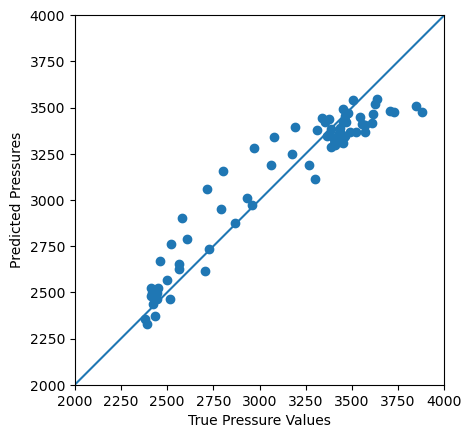

time: 187 ms (started: 2024-09-13 13:03:16 +02:00)


In [42]:
#Visualization of the accuracy:
a = plt.axes(aspect='equal')
plt.scatter(y_test, y_predicted)
plt.xlabel('True Pressure Values')
plt.ylabel('Predicted Pressures')
lims = [2000, 4000]
plt.xlim(lims), plt.ylim(lims)
plt.plot(lims, lims)

Text(0, 0.5, 'Count')

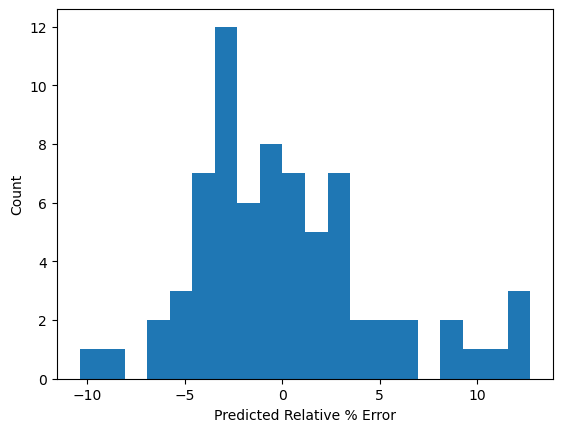

time: 156 ms (started: 2024-09-13 13:03:16 +02:00)


In [43]:
# Calculating the error variations:
error_nn = (y_predicted - y_test)/y_test*100
plt.hist(error_nn, bins=20)
plt.xlabel('Predicted Relative % Error')
plt.ylabel('Count')

In [44]:
#Calculating the mean absolutepercentage error:
abs_error_nn = abs(y_predicted - y_test)/y_test*100
np.average(error_nn)

0.2008213738371386

time: 0 ns (started: 2024-09-13 13:03:16 +02:00)


In [45]:
#Calculating R2 value:
r2_test = r2_score(y_test, y_predicted)
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  0.89
time: 0 ns (started: 2024-09-13 13:03:16 +02:00)


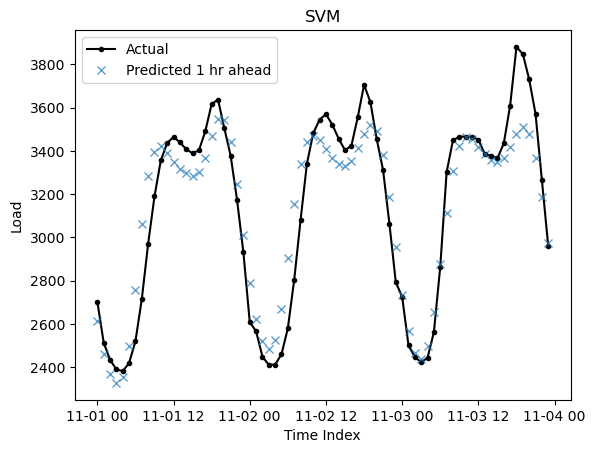

time: 266 ms (started: 2024-09-13 13:03:16 +02:00)


In [46]:
#Plotting the Figure: 
plt.figure();
plt.plot(y_test, 'k.-');
plt.plot(y_predicted, 'x', alpha=0.70);

plt.legend(['Actual',
            'Predicted 1 hr ahead'
            ]);
plt.ylabel('Load');
plt.xlabel('Time Index');
plt.title('SVM');
mpl.rcParams['figure.figsize'] = [12.0, 6.0]